In [ ]:
pip install dask

In [ ]:
pip install dask-ml

In [ ]:
###############################################################################################################
# Recherche de similarité temporelle (TSS - Temporal Similarity Search) pour la détection de pannes.         ##
# Non supervisé, basé sur la similarité vectorielle                                                          ##
# Il repose sur la distance euclidienne entre fenêtres de données pour détecter                              ##
# des comportements similaires à des pannes connues.                                                         ##
# C'est une approche de recherche vectorielle qui compare chaque fenêtre test à des fenêtres d'entraînement. ##
###############################################################################################################

Étapes
1. Chargement des données avec Dask	Dask est utilisé pour traiter efficacement des fichiers volumineux (CSV & Parquet).
2. Séparation des données en train/test	Les périodes de pannes sont utilisées pour séparer les données.
3. Génération des fenêtres temporelles	Des fenêtres glissantes (Taille = 100) sont créées pour capturer l'évolution des capteurs.
4. Sauvegarde des fenêtres en Parquet	Permet un accès plus rapide aux données traitées.
5. Recherche vectorielle (K plus proches voisins)	Compare les fenêtres de test aux fenêtres d'entraînement avec la distance euclidienne.
6. Classification des fenêtres	Vote majoritaire sur les k fenêtres les plus proches pour classer chaque fenêtre comme "normal", "en panne", ou "pré-panne".
7. Évaluation des performances	Calcul des métriques accuracy, précision, recall, F1-score.

Avantages :

Adaptée aux séries temporelles car elle prend en compte des fenêtres glissantes.
Pas besoin d’entraîner un modèle complexe comme un réseau de neurones.
Scalable avec Dask, permettant de gérer de grands volumes de données.
Approche interprétable : On sait pourquoi une anomalie est détectée (distance aux fenêtres similaires).

Inconvénients :

Pas d’apprentissage automatique supervisé : Le modèle ne "généralise" pas, il compare juste des fenêtres existantes.
Dépend fortement du choix de k (nombre de voisins) : Mauvais k = mauvaises prédictions.
Standardisation nécessaire ? Sans normalisation, les capteurs avec des valeurs élevées dominent la distance euclidienne.



In [1]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import json
import time
from tqdm import tqdm
from scipy.spatial.distance import cdist
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler

In [2]:
# ==================================================
# 1. Chargement et préparation des données avec Dask
# ==================================================

# Charger les données en Dask DataFrame
df_dask = dd.read_csv(r"..\..\..\Datasources\MetroPT3_new_imputed_final.csv", delimiter=",", decimal=".", parse_dates=['timestamp'])

# Sélection des colonnes continues et catégoriques
continuous_features = ["TP2", "DV_pressure", "Oil_temperature", "Motor_current", "Reservoirs"]
categorical_features = ["COMP", "DV_eletric", "Towers", "LPS", "Pressure_switch", "Oil_level", "Caudal_impulses"]
columns_to_keep = ["timestamp", "panne"] + continuous_features + categorical_features

# Filtrer les colonnes utiles
df_dask = df_dask[columns_to_keep]

print("Données chargées avec succes.")

Données chargées avec succes.


In [3]:
display(df_dask.head(2))

,timestamp,panne,TP2,DV_pressure,Oil_temperature,Motor_current,Reservoirs,COMP,DV_eletric,Towers,LPS,Pressure_switch,Oil_level,Caudal_impulses
0,2020-04-12 11:20:00,0,9.128,-0.022,55.475,6.0175,8.648,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1,2020-04-12 11:20:10,0,9.354,-0.020,56.525,6.0075,8.892,0.0,1.0,1.0,0.0,1.0,1.0,1.0


In [4]:
df_stats = df_dask.describe().compute()
display(df_stats)

,panne,TP2,DV_pressure,Oil_temperature,Motor_current,Reservoirs,COMP,DV_eletric,Towers,LPS,Pressure_switch,Oil_level,Caudal_impulses
count,827521.000000,827521.000000,827521.000000,827521.000000,827521.000000,827521.000000,827521.000000,827521.000000,827521.000000,827521.000000,827521.000000,827521.000000,827521.000000
mean,0.064137,1.700188,0.111086,61.470701,2.496199,7.216353,0.616667,0.378005,0.706206,0.004298,0.776762,0.771022,0.772194
std,0.252120,3.167430,0.480078,7.404990,2.136503,3.392753,0.486199,0.484889,0.455499,0.065421,0.416417,0.420175,0.419417
min,0.000000,-0.032000,-0.030000,19.825000,0.020000,0.752000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-0.014000,-0.022000,52.855320,0.042500,8.108000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
50%,0.000000,-0.010000,-0.018000,61.900000,3.154775,8.628000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
75%,0.000000,1.391000,0.037660,66.950000,3.800000,9.324000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,2.000000,10.676000,7.874000,89.050000,9.270000,10.290000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
# Fonction pour standardiser une partition complete
def scale_partition(partition):
    scaler = StandardScaler()
    partition_scaled = pd.DataFrame(scaler.fit_transform(partition), columns=partition.columns, index=partition.index)
    return partition_scaled

# Appliquer `map_partitions` sur l’ensemble des colonnes continues
df_dask[continuous_features] = df_dask[continuous_features].map_partitions(
    scale_partition, meta={col: 'f8' for col in continuous_features}
)

print("Standardisation appliquée.")

Standardisation appliquée.


In [6]:
display(df_dask.head(2))

,timestamp,panne,TP2,DV_pressure,Oil_temperature,Motor_current,Reservoirs,COMP,DV_eletric,Towers,LPS,Pressure_switch,Oil_level,Caudal_impulses
0,2020-04-12 11:20:00,0,2.345061,-0.277218,-0.809684,1.648162,0.421972,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1,2020-04-12 11:20:10,0,2.416412,-0.273052,-0.667888,1.643481,0.493890,0.0,1.0,1.0,0.0,1.0,1.0,1.0


In [7]:
df_stats = df_dask.describe().compute()
display(df_stats)

,panne,TP2,DV_pressure,Oil_temperature,Motor_current,Reservoirs,COMP,DV_eletric,Towers,LPS,Pressure_switch,Oil_level,Caudal_impulses
count,827521.000000,8.275210e+05,8.275210e+05,8.275210e+05,8.275210e+05,8.275210e+05,827521.000000,827521.000000,827521.000000,827521.000000,827521.000000,827521.000000,827521.000000
mean,0.064137,-3.615777e-16,9.958508e-17,-3.114253e-15,-2.695829e-16,-1.036379e-16,0.616667,0.378005,0.706206,0.004298,0.776762,0.771022,0.772194
std,0.252120,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,0.486199,0.484889,0.455499,0.065421,0.416417,0.420175,0.419417
min,0.000000,-5.468753e-01,-2.938820e-01,-5.624009e+00,-1.158997e+00,-1.905343e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-5.411925e-01,-2.772180e-01,-1.163457e+00,-1.148466e+00,2.628095e-01,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
50%,0.000000,-5.399296e-01,-2.688860e-01,5.797431e-02,3.082496e-01,4.160774e-01,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
75%,0.000000,-9.761487e-02,-1.529464e-01,7.399473e-01,6.102502e-01,6.212207e-01,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,2.000000,2.833786e+00,1.617013e+01,3.724423e+00,3.170510e+00,9.059454e-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
# Dataset commence le 2020-04-12 11:20:00 et se termine le 2020-07-17 06:00:00
pannes = [
    {'id': 'Panne1',  'start': '2020-04-12 11:50:00', 'end': '2020-04-12 23:30:00'},
    {'id': 'Panne2',  'start': '2020-04-18 00:00:00', 'end': '2020-04-18 23:59:00'},
    {'id': 'Panne3',  'start': '2020-04-19 00:00:00', 'end': '2020-04-19 01:30:00'},
    {'id': 'Panne4',  'start': '2020-04-29 03:20:00', 'end': '2020-04-29 04:00:00'},
    {'id': 'Panne5',  'start': '2020-04-29 22:00:00', 'end': '2020-04-29 22:20:00'},
    {'id': 'Panne6',  'start': '2020-05-13 14:00:00', 'end': '2020-05-13 23:59:00'},
    {'id': 'Panne7',  'start': '2020-05-18 05:00:00', 'end': '2020-05-18 05:30:00'},
    {'id': 'Panne8',  'start': '2020-05-19 10:10:00', 'end': '2020-05-19 11:00:00'},
    {'id': 'Panne9',  'start': '2020-05-19 22:10:00', 'end': '2020-05-19 23:59:00'},
    {'id': 'Panne10', 'start': '2020-05-20 00:00:00', 'end': '2020-05-20 20:00:00'},
    {'id': 'Panne11', 'start': '2020-05-23 09:50:00', 'end': '2020-05-23 10:10:00'},
    {'id': 'Panne12', 'start': '2020-05-29 23:30:00', 'end': '2020-05-29 23:59:00'},
    {'id': 'Panne13', 'start': '2020-05-30 00:00:00', 'end': '2020-05-30 06:00:00'},
    {'id': 'Panne14', 'start': '2020-06-01 15:00:00', 'end': '2020-06-01 15:40:00'},
    {'id': 'Panne15', 'start': '2020-06-03 10:00:00', 'end': '2020-06-03 11:00:00'},
    {'id': 'Panne16', 'start': '2020-06-05 10:00:00', 'end': '2020-06-05 23:59:00'},
    {'id': 'Panne17', 'start': '2020-06-06 00:00:00', 'end': '2020-06-06 23:59:00'},
    {'id': 'Panne18', 'start': '2020-06-07 00:00:00', 'end': '2020-06-07 14:30:00'},
    {'id': 'Panne19', 'start': '2020-07-08 17:30:00', 'end': '2020-07-08 19:00:00'},
    {'id': 'Panne20', 'start': '2020-07-15 14:30:00', 'end': '2020-07-15 19:00:00'},
    {'id': 'Panne21', 'start': '2020-07-17 04:30:00', 'end': '2020-07-17 05:30:00'}
         ]

In [9]:
# =================================================
# 2. Séparation des données en entrainement et test
# =================================================
###################################################################################################
################ Train : Panne1 au 16                                                  ############
################ Test  : Panne17 au 21                                                 ############
###################################################################################################
################ Classe 0 : Pas de panne détectée                                      ############
################ Classe 1 : En plein panne                                             ############                              
################ Classe 2 : Panne prévue dans moins de 15 minutes                      ############ 
###################################################################################################


# Définition des périodes d'entrainement et de test
train_periods = [{'start': '2020-04-12 11:20:00', 'end': '2020-06-05 23:59:00'}]
test_periods  = [{'start': '2020-06-05 23:59:10', 'end': '2020-07-17 06:00:00'}]

# Séparer les données d'entrainement et de test
train_df = dd.concat([
    df_dask[(df_dask['timestamp'] >= period['start']) & (df_dask['timestamp'] <= period['end'])]
    for period in train_periods
])

test_df = dd.concat([
    df_dask[(df_dask['timestamp'] >= period['start']) & (df_dask['timestamp'] <= period['end'])]
    for period in test_periods
])

# Regrouper les partitions pour éviter les coupures temporelles
train_df = train_df.repartition(npartitions=4).reset_index(drop=True)
test_df = test_df.repartition(npartitions=1).reset_index(drop=True)

# Calcul du nombre de lignes
print(f"Entrainement : {train_df.shape[0].compute()} lignes")
print(f"Test : {test_df.shape[0].compute()} lignes")


Entrainement : 471115 lignes
Test : 356406 lignes


In [10]:
# ===============================================
# 3. Génération des fenêtres glissantes avec Dask
# ===============================================

window_size = 100  # Taille de la fenêtre
step_size = 1      # Pas de glissement

def create_windows(df):
    windows = []
    df = df.compute()  # Convertir en Pandas pour traitement en mémoire
    for i in tqdm(range(0, len(df) - window_size + 1, step_size), desc="Création des fenêtres"):
        window_data = df.iloc[i:i + window_size][continuous_features].values.flatten()
        panne_value = df.iloc[i:i + window_size]["panne"].mode()[0]  # Classe majoritaire
        windows.append({
            "index": i,
            "timestamp": df.iloc[i]["timestamp"],
            "sensor_data": window_data.tolist(),
            "panne": panne_value
        })
    return windows

# Génération des fenêtres d'entrainement et de test
print("Génération des fenêtres d'entrainement...")
train_windows = create_windows(train_df)

print("Génération des fenêtres de test...")
test_windows = create_windows(test_df)

print(f"Nombre de fenêtres d'entrainement : {len(train_windows)}")
print(f"Nombre de fenêtres de test : {len(test_windows)}")


Génération des fenêtres d'entrainement...


Création des fenêtres: 100%|██████████████████████████████████████████████████| 471016/471016 [09:55<00:00, 790.91it/s]


Génération des fenêtres de test...


Création des fenêtres: 100%|██████████████████████████████████████████████████| 356307/356307 [09:32<00:00, 622.08it/s]


Nombre de fenêtres d'entrainement : 471016
Nombre de fenêtres de test : 356307


In [11]:
# Afficher le premier vecteur d'entrainement
first_train_vector = train_windows[0]["sensor_data"]
print("Premier vecteur d'entrainement :")
print(first_train_vector)

Premier vecteur d'entrainement :
[2.345061129898853, -0.27721803139249807, -0.8096844124119623, 1.6481617083213247, 0.42197235529854094, 2.416412399803172, -0.273052037510957, -0.667888045031382, 1.643481160488645, 0.49389040080280994, 2.4776608350307736, -0.28138402527404666, -0.5362199896065579, 1.6270992430742675, 0.5546080949580539, 2.420200962806941, -0.28138402527404666, -0.4113041421522373, 1.643481160488645, 0.5722928602459885, 2.5540635222734513, -0.28138402527404666, -0.29651660665367086, 1.7101789671043268, 0.631831570048703, 2.6096291129953992, -0.273052037510957, -0.25600335883064823, 1.7242206106023654, 0.6878333267938309, 2.6595118592116935, -0.27721803139249807, -0.16147244724359602, 1.7289011584350444, 0.7391191461288423, 2.6323604910180145, 0.7851104084010525, -0.03655659978927153, 1.68209568010825, 0.7532669583591903, 2.6582490048771032, 0.8017743839272278, 0.11199197556181024, 1.6680540366102123, 0.7797941062910928, 2.430935224650954, 0.6184706531393219, 0.270668862

In [12]:
# ==============================================================================
# 4. Sauvegarde des fenêtres en format Parquet pour utilisation future avec Dask
# ==============================================================================


# Démarrer le chronometre
start_time = time.time()

# Convertir les données en JSON string pour les sauvegarder correctement dans Parquet
train_df_windows = pd.DataFrame(train_windows)
train_df_windows["sensor_data"] = train_df_windows["sensor_data"].apply(json.dumps)

# Convertir en DataFrame Dask avec plusieurs partitions
train_df_dask = dd.from_pandas(train_df_windows, npartitions=4)

# Sauvegarde en Parquet sans l'argument index=False
train_df_dask.to_parquet(r"..\Generated_Files\TSS\Model_1_TSS_POC_DASK_train_vectors.parquet")

print("Vecteurs d'entrainement sauvegardés au format Parquet.")

# Arrêter le chronometre
end_time = time.time()

# Calculer le temps d'exécution
execution_time = end_time - start_time
print(f"Temps d'exécution: {execution_time:.2f} secondes")



Vecteurs d'entrainement sauvegardés au format Parquet.
Temps d'exécution: 531.55 secondes


In [13]:
# ==========================================================
# 5.  Chargement des vecteurs d'entrainement pour prédiction
# ==========================================================

# Démarrer le chronometre
start_time = time.time()

# Charger les données d'entrainement sauvegardées
train_df_loaded = dd.read_parquet(r"..\Generated_Files\TSS\Model_1_TSS_POC_DASK_train_vectors.parquet")


# Convertir la colonne 'sensor_data' de JSON string en liste pour la recherche vectorielle
train_df_loaded["sensor_data"] = train_df_loaded["sensor_data"].apply(json.loads, meta=("sensor_data", "object"))

# Transformation en format utilisable pour la recherche vectorielle
X_train_loaded = np.vstack(train_df_loaded["sensor_data"].compute())
y_train_loaded = train_df_loaded["panne"].compute().values

print(f"Données d'entrainement chargées : {X_train_loaded.shape}")

# Vérification du nombre de partitions
print(f"Nombre de partitions dans le DataFrame Dask : {train_df_loaded.npartitions}")


# Afficher un extrait des données chargées
display(train_df_loaded.head())

# Arrêter le chronometre
end_time = time.time()
print(f"Temps d'exécution: {end_time - start_time:.2f} secondes")

Données d'entrainement chargées : (471016, 500)
Nombre de partitions dans le DataFrame Dask : 4


,index,timestamp,sensor_data,panne
0,0,2020-04-12 11:20:00,"[2.345061129898853, -0.27721803139249807, -0.8...",0
1,1,2020-04-12 11:20:10,"[2.416412399803172, -0.273052037510957, -0.667...",0
2,2,2020-04-12 11:20:20,"[2.4776608350307736, -0.28138402527404666, -0....",0
3,3,2020-04-12 11:20:30,"[2.420200962806941, -0.28138402527404666, -0.4...",0
4,4,2020-04-12 11:20:40,"[2.5540635222734513, -0.28138402527404666, -0....",0


Temps d'exécution: 3936.52 secondes


In [14]:
# Préparation du nouvel ensemble de test

test_df = dd.concat([
    df_dask[(df_dask['timestamp'] >= period['start']) & (df_dask['timestamp'] <= period['end'])]
    for period in test_periods
])

# Regrouper les partitions pour éviter les coupures temporelles
test_df = test_df.repartition(npartitions=1).reset_index(drop=True)

# Vérification du nombre de lignes et partitions
print(f"Nombre de lignes dans le test : {test_df.shape[0].compute()}")
print(f"Nombre de partitions dans le test : {test_df.npartitions}")

Nombre de lignes dans le test : 356406
Nombre de partitions dans le test : 1


In [15]:
# =======================================================================
# 6. Génération des fenêtres glissantes pour l'ensemble de test avec Dask
# =======================================================================

# Fonction pour créer des fenêtres de test
window_size = 100  # Taille de la fenêtre
step_size = 1      # Pas de glissement

def create_windows(df):
    windows = []
    df = df.compute()  # Convertir en Pandas pour traitement en mémoire
    for i in range(0, len(df) - window_size + 1, step_size):
        window_data = df.iloc[i:i + window_size][continuous_features].values.flatten()
        panne_value = df.iloc[i:i + window_size]["panne"].mode()[0]  # Classe majoritaire
        windows.append({
            "index": i,
            "timestamp": df.iloc[i]["timestamp"],
            "sensor_data": window_data.tolist(),
            "panne": panne_value
        })
    return windows

# Générer les fenêtres de test
print("Génération des fenêtres de test...")
test_windows = create_windows(test_df)

print(f"Nombre de fenêtres générées : {len(test_windows)}")

Génération des fenêtres de test...
Nombre de fenêtres générées : 356307


In [16]:
# ====================================
# 7. Prédiction sur l'ensemble de test
# ====================================

# Démarrer le chronometre
start_time = time.time()

# Fonction de recherche des k plus proches voisins en utilisant la distance euclidienne
def find_similar_windows(test_vector, train_vectors, train_labels, k=5): # a tester k = 3, k = 5, k = 10
    # Calculer les distances entre le vecteur de test et les vecteurs d'entrainement
    distances = cdist([test_vector], train_vectors, metric="euclidean")
    #distances = cdist([test_vector], train_vectors, metric="cityblock") # distance de Manhattan
    #distances = cdist([test_vector], train_vectors, metric="cosine")    # distance cosinus
    


    
    # Trouver les indices des k plus proches voisins
    nearest_indices = np.argsort(distances, axis=1)[:, :k]

    # Prédiction par vote majoritaire
    similar_pannes = train_labels[nearest_indices.flatten()]
    predicted_panne = np.bincount(similar_pannes).argmax()

    return predicted_panne

# Appliquer la prédiction sur l'ensemble de test
predictions = []
for test_sample in tqdm(test_windows, desc="Prédictions en cours"):
    test_vector = test_sample["sensor_data"]
    predicted_panne = find_similar_windows(test_vector, X_train_loaded, y_train_loaded)
    
    predictions.append({
        "timestamp": test_sample["timestamp"],
        "actual_panne": test_sample["panne"],
        "predicted_panne": predicted_panne
    })

# Convertir en DataFrame Pandas puis en Dask
predictions_df = pd.DataFrame(predictions)
predictions_dask = dd.from_pandas(predictions_df, npartitions=1)


# Arrêter le chronometre
end_time = time.time()
print(f"Temps d'exécution: {end_time - start_time:.2f} secondes")


Prédictions en cours: 100%|█████████████████████████████████████████████████| 356307/356307 [21:12:07<00:00,  4.67it/s]


Prédictions sauvegardées avec succes.
Temps d'exécution: 76337.94 secondes


In [20]:
# Sauvegarder les prédictions en format Parquet
predictions_dask.to_parquet(r"..\Generated_Files\TSS\test_predictions.parquet")
print("Prédictions sauvegardées avec succes.")

Prédictions sauvegardées avec succes.


In [21]:
# ========================================
# 8. Évaluation des performances du modele
# ========================================

# Charger les prédictions sauvegardées pour analyse
predictions_df = dd.read_parquet(r"..\Generated_Files\TSS\test_predictions.parquet").compute()

# Calcul des métriques de performance
y_true = predictions_df["actual_panne"].values
y_pred = predictions_df["predicted_panne"].values

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")

# Afficher les résultats
print(f"Exactitude (Accuracy) : {accuracy:.2f}")
print(f"Précision : {precision:.2f}")
print(f"Rappel (Recall) : {recall:.2f}")
print(f"Score F1 : {f1:.2f}")

C:\Users\usermine\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Exactitude (Accuracy) : 0.99
Précision : 0.99
Rappel (Recall) : 0.99
Score F1 : 0.99


In [22]:
# Sauvegarde au format CSV pour analyse ultérieure
predictions_df.to_csv(r"..\Generated_Files\TSS\final_predictions.csv", index=False)

print("Les prédictions finales ont été enregistrées avec succes.")


Les prédictions finales ont été enregistrées avec succes.


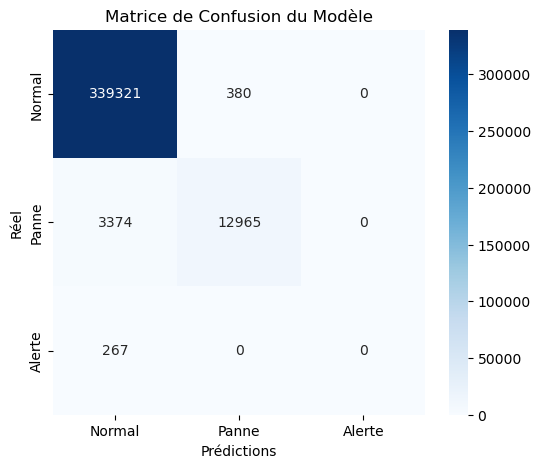

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix



# Extraire les vraies valeurs et les prédictions
y_true1 = predictions_df["actual_panne"].values
y_pred1 = predictions_df["predicted_panne"].values

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_true1, y_pred1)

# Affichage de la matrice de confusion
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Panne", "Alerte"], yticklabels=["Normal", "Panne", "Alerte"])
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.title("Matrice de Confusion du Modèle")
plt.show()


In [ ]:
Analyse des résultats :
Classe "Normal" :
339 321 échantillons ont été bien classés comme "Normal".
380 erreurs où un état normal a été classé comme "Panne" (faux positifs). 

Classe "Panne" :
12 965 pannes bien détectées.
3 374 pannes mal classées comme "Normal" (faux négatifs). Ces erreurs sont critiques car elles signifient que des pannes n'ont pas été détectées.

Classe "Alerte" :
267 observations de type "Alerte" ont été classées comme "Normal".
Aucune prédiction correcte pour la classe "Alerte" → Le modèle ne reconnaît pas cette classe du tout.

In [25]:
# Vérifier les valeurs uniques dans la colonne "panne" (lazy computation)
print("Modalités de la classe 'panne' dans train_df :")
print(train_df["panne"].value_counts().compute())

print("\nModalités de la classe 'panne' dans test_df :")
print(test_df["panne"].value_counts().compute())

Modalités de la classe 'panne' dans train_df :
0    436164
1     33766
2      1185
Name: panne, dtype: int64

Modalités de la classe 'panne' dans test_df :
0    339747
1     16379
2       280
Name: panne, dtype: int64


In [27]:
# Charger les données
df2 = pd.read_csv(r"..\..\..\Datasources\MetroPT3_imputed_8.csv", delimiter=",", decimal=".", index_col=0)
df2.reset_index(drop=True, inplace=True)

In [28]:
display(df2.head(3))

,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,...,Oil_temperature_is_missing,Motor_current_is_missing,COMP_is_missing,DV_eletric_is_missing,Towers_is_missing,MPG_is_missing,LPS_is_missing,Pressure_switch_is_missing,Oil_level_is_missing,Caudal_impulses_is_missing
0,2020-02-01 00:00:00,-0.012,9.358,9.340,-0.024,9.358,53.600,0.0400,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,2020-02-01 00:00:10,-0.014,9.348,9.332,-0.022,9.348,53.675,0.0400,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,2020-02-01 00:00:20,-0.012,9.338,9.322,-0.022,9.338,53.600,0.0425,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
start_time2 = "2020-02-01 00:00:00"
end_time2   = "2020-02-12 00:00:00"   

# Convertir timestamp
df2['timestamp'] = pd.to_datetime(df2['timestamp'], errors='coerce')

#Filtrer les données entre ces deux timestamps
df2 = df2[(df2["timestamp"] >= start_time2) & (df2["timestamp"] <= end_time2)]


In [32]:
df2.to_csv(r"..\..\..\Datasources\MetroPT3_mini_test_tss.csv", index=False)

In [34]:
#######################################
## Prédiction sur un nouveau fichier ##
#######################################

# Charger les nouvelles données
file_path = r"..\..\..\Datasources\MetroPT3_mini_test_tss.csv"  # 
new_data = dd.read_csv(file_path)


scaler = StandardScaler()
new_data[continuous_features] = new_data[continuous_features].map_partitions(lambda df: pd.DataFrame(scaler.fit_transform(df), columns=df.columns))

# Génération des fenêtres glissantes pour les nouvelles données
window_size = 100  # Taille de la fenêtre
step_size = 1      # Pas de glissement

def create_windows(df):
    windows = []
    df = df.compute()  # Convertir en Pandas pour traitement en mémoire
    for i in tqdm(range(0, len(df) - window_size + 1, step_size), desc="Génération des fenêtres"):
        window_data = df.iloc[i:i + window_size][continuous_features].values.flatten()
        timestamp = df.iloc[i]["timestamp"]
        windows.append({
            "index": i,
            "timestamp": timestamp,
            "sensor_data": window_data.tolist()
        })
    return windows

print("Génération des fenêtres pour les nouvelles données...")
new_windows = create_windows(new_data)


Génération des fenêtres pour les nouvelles données...


Génération des fenêtres: 100%|██████████████████████████████████████████████████| 94942/94942 [01:39<00:00, 954.05it/s]


In [ ]:
# Charger les vecteurs d'entraînement sauvegardés
train_df_loaded = dd.read_parquet(r"..\Generated_Files\TSS\Model_1_TSS_POC_DASK_train_vectors.parquet")
train_df_loaded["sensor_data"] = train_df_loaded["sensor_data"].apply(json.loads, meta=("sensor_data", "object"))

# Transformation des données pour la recherche de similarité
X_train_loaded = np.vstack(train_df_loaded["sensor_data"].compute())
y_train_loaded = train_df_loaded["panne"].compute().values

print(f"Données d'entraînement chargées : {X_train_loaded.shape}")

# Prédiction avec la recherche des plus proches voisins (TSS)
def find_similar_windows(test_vector, train_vectors, train_labels, k=5):
    distances = cdist([test_vector], train_vectors, metric="euclidean")
    nearest_indices = np.argsort(distances, axis=1)[:, :k]
    similar_pannes = train_labels[nearest_indices.flatten()]
    predicted_panne = np.bincount(similar_pannes).argmax()
    return predicted_panne

# Appliquer la prédiction sur le nouveau dataset
predictions = []
for test_sample in tqdm(new_windows, desc="Prédictions en cours"):
    test_vector = test_sample["sensor_data"]
    predicted_panne = find_similar_windows(test_vector, X_train_loaded, y_train_loaded)
    
    predictions.append({
        "timestamp": test_sample["timestamp"],
        "predicted_panne": predicted_panne
    })

# Sauvegarde des prédictions
predictions_df = pd.DataFrame(predictions)
predictions_dask = dd.from_pandas(predictions_df, npartitions=1)

predictions_dask.to_parquet(r"..\Generated_Files\TSS\new_predictions2.parquet")
predictions_df.to_csv(r"..\Generated_Files\TSS\new_predictions2.csv", index=False)

print("Prédictions sauvegardées avec succès sous Parquet et CSV !")